# Labeled Faces In The Wild Deep Learning Classification


## Desription

The LFW (Labeled Faces In The Wild) dataset is composed of 5479 clases (different persons) for more than 13000 images.

## Initialization

In [ ]:
DATASET_PATH = "../datasets/lfw_funneled"

## Load and split dataset

In [ ]:
import tensorflow as tf

batch_size = 8
SEED = 123
w, h, l = 94, 125, 3
IMG_SHAPE = (h, w, l)

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(h, w),
    batch_size=batch_size,
    label_mode="categorical",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(h, w),
    batch_size=batch_size,
    label_mode="categorical",
)

class_names = train_ds.class_names
n_classes = len(class_names)

## Show images infos

In [ ]:
print(class_names)
print(f"Image dimensions: {w}x{h}x{l}")
print(f"Number of classes: {n_classes}")

## Show images

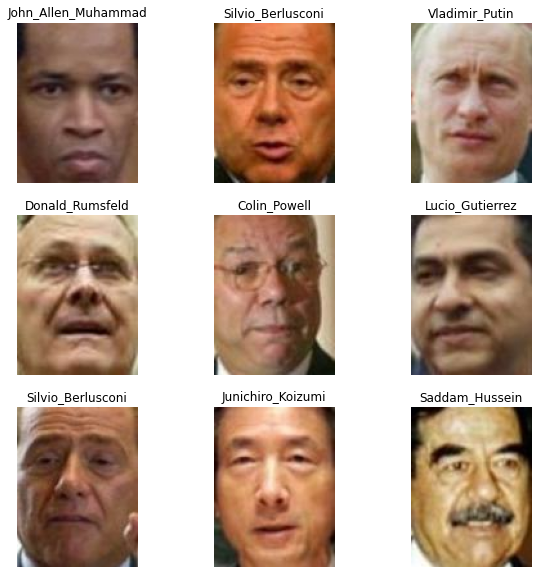

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if i >= 8:
            images, labels = val_ds.as_numpy_iterator().next()
            plt.imshow(images[0].astype("uint8"))
            plt.title(class_names[np.argmax(labels[0])])
        else:
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
print("Number of validation batches: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of test batches: %d" % tf.data.experimental.cardinality(val_ds))

## Configure dataset performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [ ]:
"""
tf.keras.layers.RandomCrop
tf.keras.layers.RandomFlip
tf.keras.layers.RandomTranslation
tf.keras.layers.RandomRotation
tf.keras.layers.RandomZoom
tf.keras.layers.RandomHeight
tf.keras.layers.RandomWidth
tf.keras.layers.RandomContrast
"""

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
        tf.keras.layers.RandomTranslation(
            height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode="nearest"
        ),
        tf.keras.layers.RandomBrightness((-0.1, 0.1)),
        # tf.keras.layers.Random
    ]
)

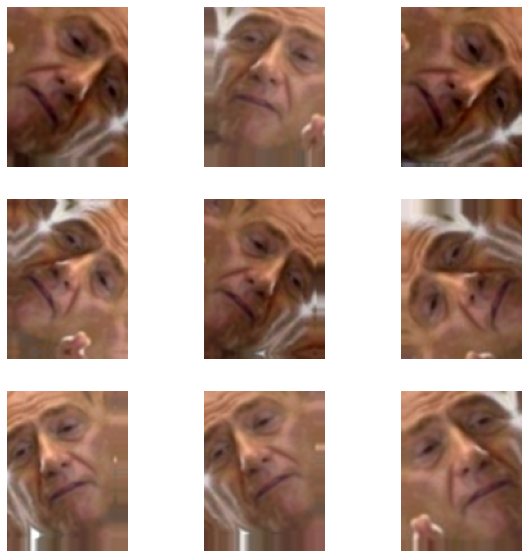

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")
## Not displaying correctly in Jupyter for unknown reason

## Rescale pixel values

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Building model


In [ ]:
from keras.optimizers import SGD
from keras.layers import Dense
from keras.layers import Flatten
from keras.applications import ResNet50
import tensorflow as tf

# Change input shape to add image preprocessing
inputs = tf.keras.Input(shape=IMG_SHAPE)
y = preprocess_input(inputs)

# Create ResNet50 model
resnet = ResNet50(
    input_shape=[h, w, 3],
    weights="imagenet",
    include_top=False,
    classes=n_classes,
)

# Freeze layers for transfer learning
for layer in resnet.layers[:10]:
    layer.trainable = False
# resnet.trainable = False

# Add ResNet50 to the final model output
outputs = resnet(y)

# Change the ResNet50 output to be the number of class of the dataset
x = Flatten()(outputs)
x = Dense(n_classes, activation="softmax")(x)

# Assemble model
model = tf.keras.Model(inputs, x)

learning_rate = 0.001
nesterov = True
momentum = 0.9

opti = SGD(
    learning_rate=learning_rate,
    momentum=momentum,
    nesterov=nesterov,
)

model.compile(
    loss=tf.keras.losses.categorical_crossentropy, optimizer=opti, metrics=["accuracy"]
)

model.summary()

# model.save("../models/resnet50_dl_lfw_empty")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 125, 94, 3)]      0         
                                                                 
 tf.__operators__.getitem (S  (None, 125, 94, 3)       0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 125, 94, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 4, 3, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 158)               3883166   
                                                             

## Training

In [23]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", patience=2)
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])

Epoch 1/50
433/433 [==============================] - 19s 42ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 1.0027 - val_accuracy: 0.7697
Epoch 2/50
433/433 [==============================] - 20s 45ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 1.0101 - val_accuracy: 0.7581
Epoch 3/50
433/433 [==============================] - 21s 48ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.9911 - val_accuracy: 0.7650


## Save model

In [ ]:
# model.save_weights("../weights/resnet50_dl_lfw.h5")
# model.save("../models/resnet50_dl_lfw")

## Learning curvres

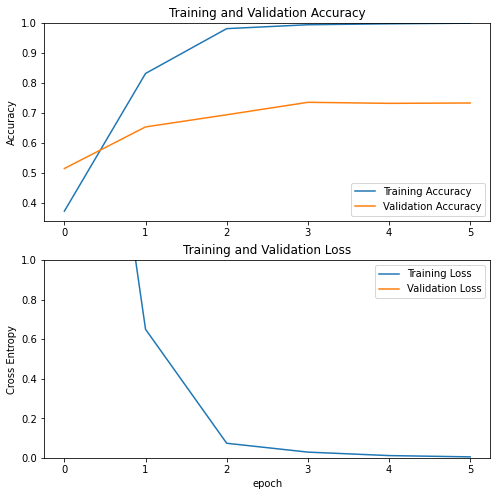

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

## Predict images

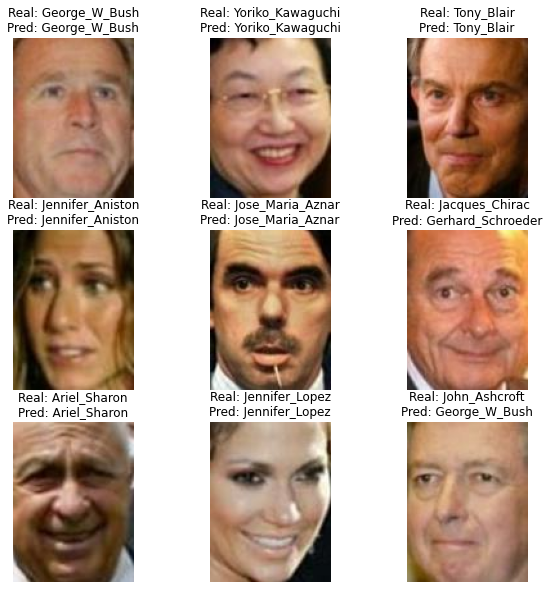

In [19]:
import numpy as np

image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    if i >= 8:
        image_batch, label_batch = val_ds.as_numpy_iterator().next()
        plt.imshow(image_batch[0].astype("uint8"))
        plt.title(
            f"Real: {class_names[np.argmax(label_batch[0])]}\nPred: {class_names[np.argmax(predictions[0])]}"
        )
    else:
        plt.imshow(image_batch[i].astype("uint8"))
        plt.title(
            f"Real: {class_names[np.argmax(label_batch[i])]}\nPred: {class_names[np.argmax(predictions[i])]}"
        )
    plt.axis("off")